# Building Frederike's third force field

In [1]:
import matplotlib.pyplot as plt
import ase.io as io
from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.optimize import BFGS
Fit_on_forces=False

In [2]:
import os
print(os.getcwd())

/home/thism292/Documents/repos/Tantalizing/third_run/CCS


### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


for i in {1..19}; do (mkdir "outcar${i}"; mv "outcar${i}.txt" "outcar${i}/OUTCAR"); done
for i in {1..19}; do (echo "outcar/outcar${i}" >> data_list.txt); done
for f in $(ls OUTCARS/); do echo "OUTCARS/$f" >> data_list.txt; done

In [49]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS",DFT_DB="DFT.db",file_list="data_list.txt",overwrite=True, greedy=False)

    Building data-bases: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 105.12it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``DFT_DB`` since the most common source of reference data is DFT.

In [50]:
!ase db DFT.db

id|age|user    |formula    |calculator|  energy|natoms| fmax|pbc| volume|charge|    mass| smax|magmom
 1| 4s|thism292|Li13Ni27O54|vasp      |-574.107|    94|0.018|TTT|868.408| 0.000|2538.888|0.001| 9.359
 2| 4s|thism292|Li17Ni27O54|vasp      |-595.854|    98|0.018|TTT|884.767| 0.000|2566.648|0.001|17.010
 3| 4s|thism292|Li20Ni27O54|vasp      |-611.175|   101|0.013|TTT|888.860| 0.000|2587.468|0.001|20.000
 4| 4s|thism292|Li4Ni27O54 |vasp      |-528.892|    85|0.011|TTT|856.196| 0.000|2476.428|0.000| 3.992
 5| 4s|thism292|Li7Ni27O54 |vasp      |-545.210|    88|0.015|TTT|863.845| 0.000|2497.248|0.000| 4.935
 6| 4s|thism292|Li18Ni27O54|vasp      |-601.983|    99|0.019|TTT|884.190| 0.000|2573.588|0.001|18.004
 7| 4s|thism292|Li20Ni27O54|vasp      |-611.432|   101|0.014|TTT|887.953| 0.000|2587.468|0.000|19.985
 8| 4s|thism292|Li16Ni27O54|vasp      |-591.886|    97|0.020|TTT|886.356| 0.000|2559.708|0.000|16.000
 9| 4s|thism292|Li15Ni27O54|vasp      |-586.868|    96|0.019|TTT|887.602| 0.000|25

In [51]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="DFT.db",include_forces=Fit_on_forces)

    Fetching data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 55.96it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.


In [52]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [53]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Generating two-body potentials from one-body information.
    Adding pair: Li-Ni
    Adding pair: Li-O
    Adding pair: Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Merging intervals for pair Ni-Ni; number of intervals reduced from 16 to 12. 
    Merging intervals for pair Li-Li; number of intervals reduced from 15 to 12. 
    Merging intervals for pair Li-Ni; number of intervals reduced from 12 to 10. 
    Merging intervals for pair Li-O; number of intervals reduced from 18 to 13. 
    Merging intervals for pair Ni-O; number of intervals reduced from 19 to 16. 
    There is linear dependence in stochiometry matr

    Finding optimum switch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2080/2080 [00:08<00:00, 251.55it/s]

    The best switch is (17, 12, 12, 7, 12, 0) with rmse: 0.04275160815688692, corresponding to distances of [6.34 5.47 5.55 4.34 4.82 1.56] Å for element pairs ['O-O', 'Ni-Ni', 'Li-Li', 'Li-Ni', 'Li-O', 'Ni-O'].



/home/thism292/Documents/repos/CCS_fit/src/ccs_fit/fitting/spline_functions.py:321: RuntimeWarning: invalid value encountered in log
  beta = alpha * r0 + np.log(cc / alpha**2)


### 2nd iteration of fitting

In [54]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "full",
                        "range_center": 4.34,
                        "range_width": 0.5
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "full",
                        "range_center": 4.82,
                        "range_width": 0.5
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.56,
                        "range_width": 0.5
                },
                "O-O": {
                        "Rcut": 8.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 5.78,
                        "range_width": 0.5
                },
                "Ni-Ni": {
                        "Rcut": 8.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.1,
                        "range_width": 0.5
                },
                "Li-Li": {
                        "Rcut": 8.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 5.02,
                        "range_width": 0.5
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [55]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging intervals for pair Li-Ni; number of intervals reduced from 27 to 18. 
    Merging intervals for pair Li-O; number of intervals reduced from 43 to 26. 
    Merging intervals for pair Ni-O; number of intervals reduced from 45 to 36. 
    Merging intervals for pair Ni-Ni; number of intervals reduced from 36 to 25. 
    Merging intervals for pair Li-Li; number of intervals reduced from 35 to 24. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Range search turned on for element pair Ni-O; 2 possible switch indices in range of 1.64-2.0

    Finding optimum switch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46800/46800 [20:10<00:00, 38.66it/s]

    The best switch is (14, 25, 0, 34, 18, 22) with rmse: 0.026795148814664195, corresponding to distances of [4.07 4.39 1.64 5.57 4.35 4.82] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].



/home/thism292/Documents/repos/CCS_fit/src/ccs_fit/fitting/spline_functions.py:321: RuntimeWarning: invalid value encountered in log
  beta = alpha * r0 + np.log(cc / alpha**2)


In [56]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.07,
                        "range_width": 0.5
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.39,
                        "range_width": 0.5
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.64,
                        "range_width": 0.5
                },
                "O-O": {
                        "Rcut": 8.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 5.57,
                        "range_width": 0.1
                },
                "Ni-Ni": {
                        "Rcut": 8.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.35,
                        "range_width": 0.1
                },
                "Li-Li": {
                        "Rcut": 8.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.82,
                        "range_width": 0.1
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [57]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging intervals for pair Li-Ni; number of intervals reduced from 27 to 18. 
    Merging intervals for pair Li-O; number of intervals reduced from 43 to 26. 
    Merging intervals for pair Ni-O; number of intervals reduced from 45 to 36. 
    Merging intervals for pair Ni-Ni; number of intervals reduced from 36 to 25. 
    Merging intervals for pair Li-Li; number of intervals reduced from 35 to 24. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Range search turned on for element pair Li-Ni; 5 possible switch indices in range of 3.57-4.

    Finding optimum switch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 41.06it/s]


    The best switch is (14, 25, 2, 34, 18, 22) with rmse: 0.02673836195431575, corresponding to distances of [4.07 4.39 1.84 5.57 4.35 4.82] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].


In [60]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.07,
                        "range_width": 0.1
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.39,
                        "range_width": 0.1
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.84,
                        "range_width": 0.2
                },
                "O-O": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [5.57],
                        "range_width": 0.1
                },
                "Ni-Ni": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [4.35],
                        "range_width": 0.1
                },
                "Li-Li": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [4.82],
                        "range_width": 0.1
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [61]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging intervals for pair Li-Ni; number of intervals reduced from 125 to 73. 
    Merging intervals for pair Li-O; number of intervals reduced from 205 to 104. 
    Merging intervals for pair Ni-O; number of intervals reduced from 218 to 162. 
    Merging intervals for pair O-O; number of intervals reduced from 191 to 190. 
    Merging intervals for pair Ni-Ni; number of intervals reduced from 172 to 104. 
    Merging intervals for pair Li-Li; number of intervals reduced from 168 to 109. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    R

    Finding optimum switch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


    The best switch is (66, 121, 9, 169, 90, 108) with rmse: 0.021869156362329115, corresponding to distances of [4.03 4.35 1.86 5.59 4.39 4.82] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].


### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [1]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="DFT.db")

  0%|                                                                                                                                                                                                                                    | 0/82 [00:00<?, ?it/s]/home/thism292/anaconda3/envs/CCS_fit/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:08<00:00,  9.27it/s]


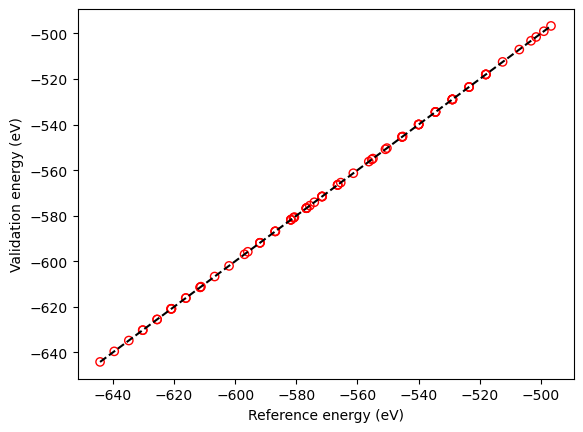

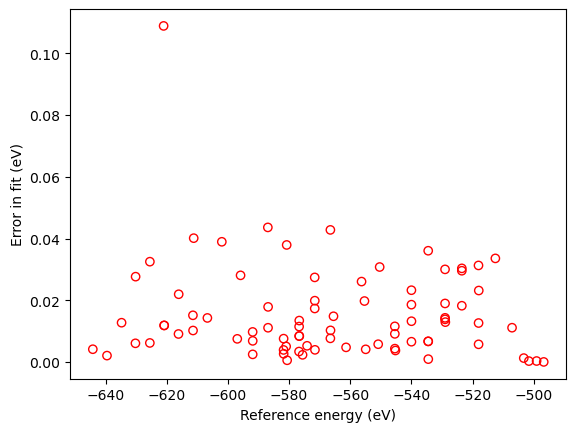

In [63]:
try:
    err=np.loadtxt("CCS_validate.dat")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Validation energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

### Cleaning up

In [11]:
# import glob

# def rm(file):
#     try:
#         os.remove(file)
#     except OSError:
#         pass


# list=glob.glob("CALCULATED_DATA/*")
# for file in list:
#     rm(file)
# list=glob.glob("CCS_*")
# for file in list:
#     rm(file)
# list=glob.glob("UNC_*")
# for file in list:
#     rm(file)
# rm("structures.json")
# rm("file_list")
# rm("LJ.db")

### Convex hull

In [64]:
struct_no_Li = io.read('DFT.db@21')
struct_full_Li = io.read('DFT.db@10')

nrg_0 = struct_no_Li.get_potential_energy()
nrg_1 = struct_full_Li.get_potential_energy()

print(struct_no_Li.get_chemical_formula())
print(struct_full_Li.get_chemical_formula())

Ni27O54
Li27Ni27O54


Text(0, 0.5, 'Energy')

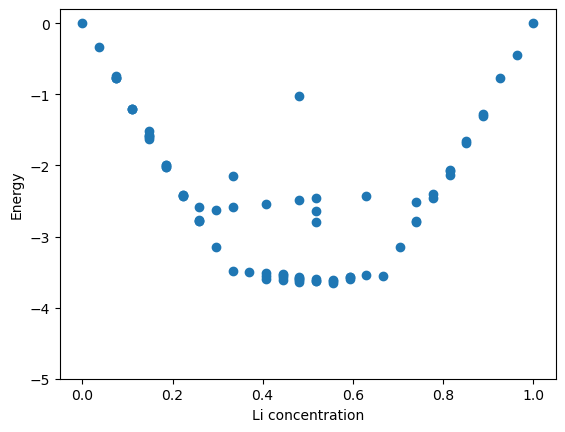

In [65]:
# CCS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS 
from ase import io
import json
import ase.db as db
import matplotlib.pyplot as plt

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)

nrg_Li = CCS_params['One_body']['Li']
    
CCS_calc=CCS(CCS_params=CCS_params)
    
DFT_DB = db.connect('DFT.db')
    
xs = []
CCS_nrgs = []

i = 0

struct_no_Li_CCS = struct_no_Li.copy()
struct_full_Li_CCS = struct_full_Li.copy()

struct_no_Li_CCS.calc = CCS_calc
struct_full_Li_CCS.calc = CCS_calc

ECCS_no_Li = struct_no_Li_CCS.get_potential_energy()
ECCS_full_Li = struct_full_Li_CCS.get_potential_energy()

for row in DFT_DB.select():
    structure = row.toatoms()
    # print(structure.get_magnetic_moments())
    elems = structure.get_chemical_symbols()
    nr_Li = elems.count('Li')
    nr_Ni = elems.count('Ni')
    x = nr_Li/nr_Ni
    EDFT = structure.get_potential_energy()
    structure.calc = CCS_calc
    ECCS = structure.get_potential_energy() - (ECCS_no_Li) - (ECCS_full_Li-ECCS_no_Li)/27*nr_Li
    xs.append(x)
    CCS_nrgs.append(ECCS)
    i += 1

plt.ylim(-5, 0.2)
plt.scatter(xs, CCS_nrgs)
plt.xlabel("Li concentration")
plt.ylabel("Energy")

Text(0, 0.5, 'Energy')

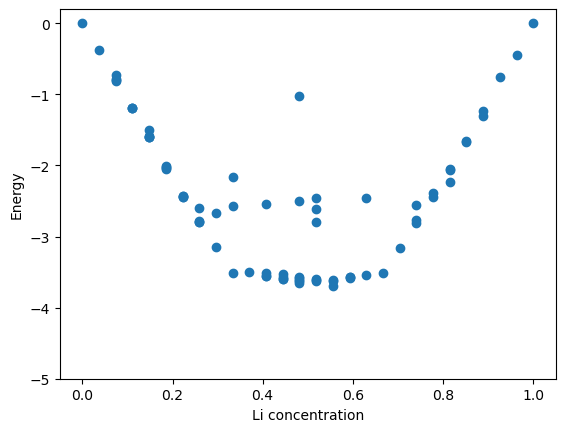

In [66]:
# CCS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS 
from ase import io
import json
import ase.db as db

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)

nrg_Li = CCS_params['One_body']['Li']
    
CCS_calc=CCS(CCS_params=CCS_params)
    
DFT_DB = db.connect('DFT.db')
    
xs = []
DFT_nrgs = []

i = 0

for row in DFT_DB.select():
    structure = row.toatoms()
    # print(i)
    # print(dir(structure))
    # print(structure.get_magnetic_moment())
    elems = structure.get_chemical_symbols()
    nr_Li = elems.count('Li')
    nr_Ni = elems.count('Ni')
    x = nr_Li/nr_Ni
    EDFT = structure.get_potential_energy() - (nrg_0) - (nrg_1-nrg_0)/27*nr_Li
    xs.append(x)
    DFT_nrgs.append(EDFT)
    i += 1

plt.ylim(-5, 0.2)
plt.scatter(xs, DFT_nrgs)
plt.xlabel("Li concentration")
plt.ylabel("Energy")

In [36]:
print(io.read('DFT.db@80').get_chemical_formula())

Ni27O54


In [70]:
from ase.optimize import BFGS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from tqdm import tqdm
from ase import io

struct = io.read('DFT.db@10')

struct = struct * [2,2,2]

CCS_calc = CCS(CCS_params=CCS_params)

# struct.rattle(0.05)
struct.calc = CCS_calc

opt = BFGS(struct, trajectory='opt.traj')
opt.run(fmax=0.0001)

      Step     Time          Energy         fmax
BFGS:    0 10:41:34    -5153.287470        0.5704
BFGS:    1 10:41:35    -5154.924206        0.3601
BFGS:    2 10:41:37    -5156.018157        0.0039
BFGS:    3 10:41:39    -5156.018284        0.0001


True

In [71]:
!ase gui opt.traj

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/pipe.py", line 19, in main
    make_plot(show=False, *data)
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/graphs.py", line 78, in make_plot
    plt.figure(figsize=(basesize * 2.5**0.5, basesize))
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/_api/deprecation.py", line 454, in wrapper
    return func(*args, **kwargs)
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/pyplot.py", line 783, in figure
    manager = new_figure_manager(
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/pyplot.py", 

In [72]:
# Read geometry optimized structure and run NVE Molecular dynamics 
import numpy as np
from ase import units
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.md import MDLogger
from ase.md.verlet import VelocityVerlet

dt = 0.5 * units.fs
steps = int(300)
dyn = VelocityVerlet(struct, timestep=dt)
interval = int(1)
dyn.attach(MDLogger(dyn, struct, 'output.log', mode="a"), interval=interval)
dyn.attach(Trajectory('output.traj', 'a', struct).write, interval=interval)
dyn.run(steps)

True

In [73]:
!ase gui output.traj

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/pipe.py", line 19, in main
    make_plot(show=False, *data)
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/graphs.py", line 78, in make_plot
    plt.figure(figsize=(basesize * 2.5**0.5, basesize))
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/_api/deprecation.py", line 454, in wrapper
    return func(*args, **kwargs)
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/pyplot.py", line 783, in figure
    manager = new_figure_manager(
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/pyplot.py", 

In [11]:
## Stresses not currently implemented in ccs_fit yet!
from ase import io
from ase.constraints import StrainFilter
from ase.optimize import BFGS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
import json

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)

struct = io.read('DFT.db@10')
struct = struct # * [2,2,2]

CCS_calc = CCS(CCS_params=CCS_params)
struct.calc = CCS_calc

sf = StrainFilter(struct)
opt = BFGS(sf, trajectory="strain.traj")
opt.run(0.005)

      Step     Time          Energy         fmax
BFGS:    0 11:50:33     -644.160934      168.2128
BFGS:    1 11:50:34     -618.307712      962.7039
BFGS:    2 11:50:34     -641.370457      926.0122
BFGS:    3 11:50:34     -685.457270      263.6745
BFGS:    4 11:50:34     -690.714326      131.0993
BFGS:    5 11:50:34     -692.776762      186.1767
BFGS:    6 11:50:34     -697.762451      114.1498
BFGS:    7 11:50:34     -698.306111      100.1626
BFGS:    8 11:50:34     -696.740793      144.2429
BFGS:    9 11:50:34     -695.369286      255.7066
BFGS:   10 11:50:34     -699.528439       83.4098
BFGS:   11 11:50:34     -700.385711       36.2512
BFGS:   12 11:50:34     -695.830411      117.7843
BFGS:   13 11:50:35     -700.866373       14.1685
BFGS:   14 11:50:35     -699.328262       54.9023
BFGS:   15 11:50:35     -700.970581       11.5703
BFGS:   16 11:50:35     -700.853850       17.6003
BFGS:   17 11:50:35     -701.008541        9.1961
BFGS:   18 11:50:35     -701.010223        6.6111
B

True

In [8]:
!ase gui strain.traj

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/pipe.py", line 19, in main
    make_plot(show=False, *data)
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/graphs.py", line 78, in make_plot
    plt.figure(figsize=(basesize * 2.5**0.5, basesize))
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/_api/deprecation.py", line 454, in wrapper
    return func(*args, **kwargs)
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/pyplot.py", line 783, in figure
    manager = new_figure_manager(
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/pyplot.py", 